# Project 2: Implementing a Simple Convolutional Neural Network (CNN)

## Introduction

In this project, you will design, implement, and evaluate a simple Convolutional Neural Network (CNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Convolutional Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project! Kaggle would be a good source to look for datasets. Below are some examples:
- CIFAR-10: A dataset of 60,000 32x32 color images in 10 classes with 6,000 images per class.
- MNIST: A dataset of 70,000 28x28 grayscale images of handwritten digits (0-9).
- Fashion-MNIST: A dataset of 70,000 28x28 grayscale images of 10 different clothing caregories.


In [6]:
import os
import shutil
import random

def organize_dataset(base_dir, train_ratio=0.8):
    # Define paths
    categories = ['tumor', 'healthy']
    dataset_dir = os.path.join(base_dir, 'dataset')
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    
    # Create new folder (train/val)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    
    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        images = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
        
        # Shuffle and split image
        random.shuffle(images)
        split_idx = int(train_ratio * len(images))
        train_images = images[:split_idx]
        val_images = images[split_idx:]
        
        # Create sub folders with in train/val (tumor/healthu)
        train_category_path = os.path.join(train_dir, category)
        val_category_path = os.path.join(val_dir, category)
        os.makedirs(train_category_path, exist_ok=True)
        os.makedirs(val_category_path, exist_ok=True)
        
        # Copy and rename images to train directory
        for i, img in enumerate(train_images):
            src = os.path.join(category_path, img)
            dst = os.path.join(train_category_path, f"{category}_{i}.png")
            shutil.copyfile(src, dst)
        
        # Copy and rename images to val directory
        for i, img in enumerate(val_images):
            src = os.path.join(category_path, img)
            dst = os.path.join(val_category_path, f"{category}_{i}.png")
            shutil.copyfile(src, dst)
            
    print("Dataset organized successfully.")

base_dir = ''
organize_dataset(base_dir)


Dataset organized successfully.


In [123]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# resize 224x224 pixel, random flip/rotate 45 degree, change range 0-255 to 0-1
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}

# Load datasets
data_dir = ''
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

# Create dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(class_names)


['healthy', 'tumor']


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet18_Weights

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# Create a ResNet-18 model instance
model = ResNet18()

# Change the fully connected layer to match the number of classes (2 in this case)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming 2 classes: 'healthy' and 'tumor'

# Move the model to GPU 
device = torch.device("cuda:0")
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Check the number of available GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of available GPUs: {num_gpus}")

# Print the name and properties of each GPU
for i in range(num_gpus):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")
    print(f"  - Memory Allocated: {torch.cuda.memory_allocated(i) / 1024 ** 2:.2f} MB")
    print(f"  - Memory Cached: {torch.cuda.memory_reserved(i) / 1024 ** 2:.2f} MB")

# print(model)
# Check if the model is on the GPU
for param in model.parameters():
    print(param.device)

Number of available GPUs: 1
Device 0: NVIDIA GeForce RTX 2060
  - Memory Allocated: 42.69 MB
  - Memory Cached: 64.00 MB
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


Epoch 0/24
----------
train Loss: 0.1741 Acc: 0.9478
val Loss: 0.1055 Acc: 0.9587

Epoch 1/24
----------
train Loss: 0.0833 Acc: 0.9671
val Loss: 0.0365 Acc: 0.9946

Epoch 2/24
----------
train Loss: 0.0706 Acc: 0.9739
val Loss: 0.0308 Acc: 0.9891

Epoch 3/24
----------
train Loss: 0.0506 Acc: 0.9818
val Loss: 0.0287 Acc: 0.9957

Epoch 4/24
----------
train Loss: 0.0397 Acc: 0.9842
val Loss: 0.0406 Acc: 0.9848

Epoch 5/24
----------
train Loss: 0.0408 Acc: 0.9861
val Loss: 0.0335 Acc: 0.9913

Epoch 6/24
----------
train Loss: 0.0424 Acc: 0.9853
val Loss: 0.0356 Acc: 0.9881

Epoch 7/24
----------
train Loss: 0.0326 Acc: 0.9908
val Loss: 0.0426 Acc: 0.9848

Epoch 8/24
----------
train Loss: 0.0385 Acc: 0.9880
val Loss: 0.0210 Acc: 0.9935

Epoch 9/24
----------
train Loss: 0.0280 Acc: 0.9899
val Loss: 0.0172 Acc: 0.9946

Epoch 10/24
----------
train Loss: 0.0225 Acc: 0.9918
val Loss: 0.0271 Acc: 0.9957

Epoch 11/24
----------
train Loss: 0.0348 Acc: 0.9891
val Loss: 0.0231 Acc: 0.9935

Ep

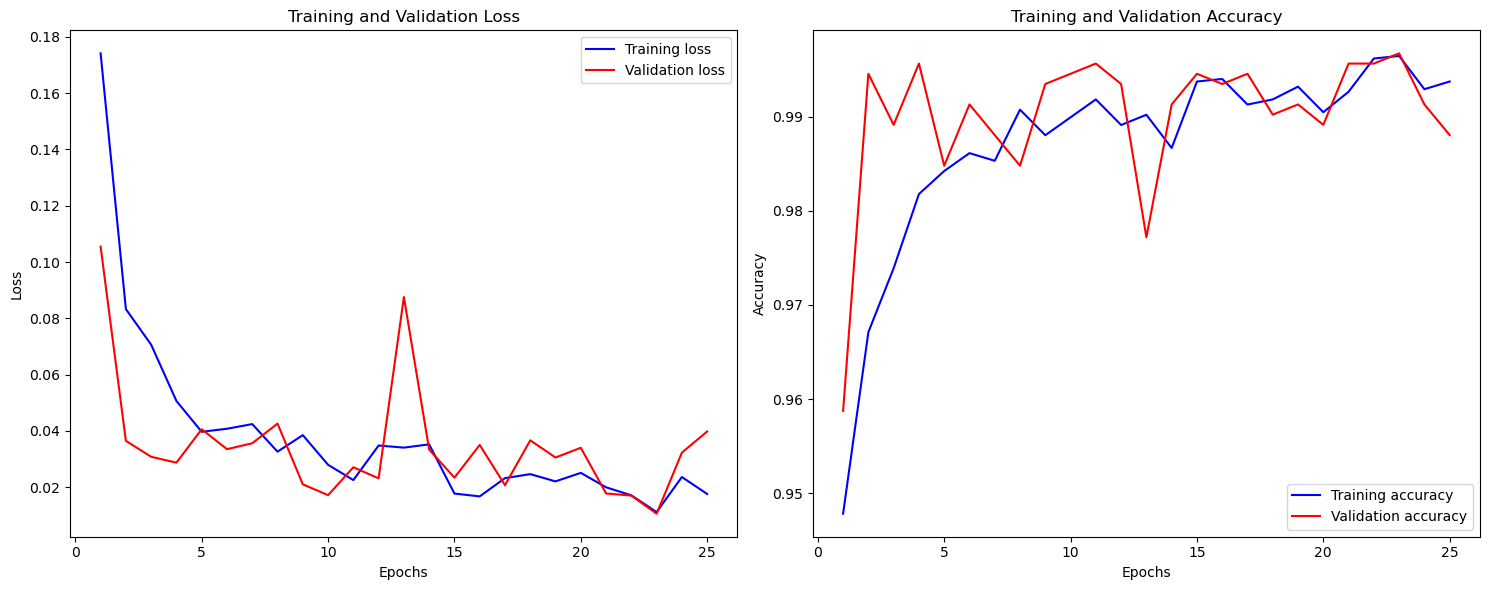

In [125]:
import time
import copy
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define DataLoader for training and validation datasets
batch_size = 32
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu().detach().numpy())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu().detach().numpy())

            # Deep copy the model if it has the best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Return metrics
    return model, train_losses, train_accs, val_losses, val_accs

# Train the model
model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, num_epochs=25)

# Function to plot training and validation metrics
def plot_metrics(train_losses, train_accs, val_losses, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 6))

    # Plotting losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b', label='Training accuracy')
    plt.plot(epochs, val_accs, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(train_losses, train_accs, val_losses, val_accs)

In [281]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Confusion Matrix:
[[416   2]
 [  1 502]]

Classification Report:
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00       418
       tumor       1.00      1.00      1.00       503

    accuracy                           1.00       921
   macro avg       1.00      1.00      1.00       921
weighted avg       1.00      1.00      1.00       921



In [159]:
# Save the trained model
torch.save(model.state_dict(), 'brain_tumor_classifier.pth')
print("Model saved successfully.")

Model saved successfully.


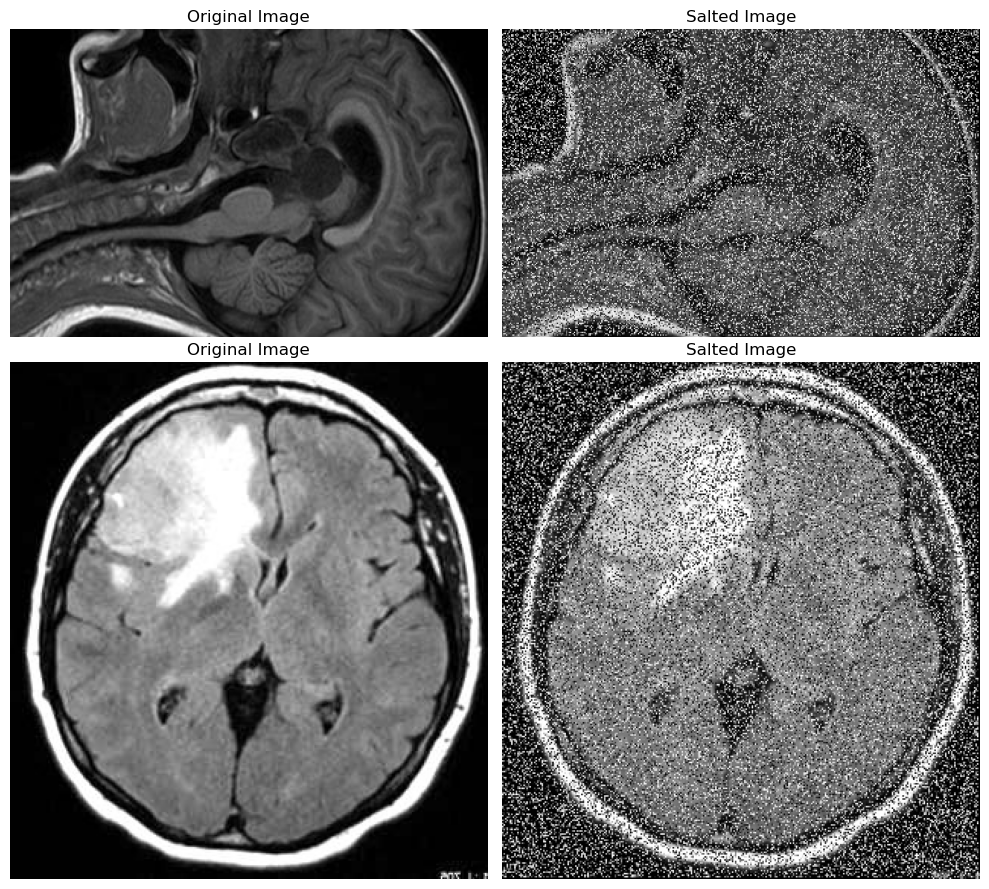

healthy
Origin Predicted class: healthy
Salted Predicted class: healthy
tumor
Origin Predicted class: tumor
Salted Predicted class: tumor


In [271]:
from PIL import Image

def predict(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path)
    transform = data_transforms['val']
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

    predicted_class = class_names[preds[0]]
    return predicted_class

# Function to add salt noise to an image
def add_salt_noise(image, amount):
    noisy_image = np.copy(image)
    height, width, _ = image.shape
    num_salt = np.ceil(amount * image.size)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    for coord_x, coord_y in zip(coords[0], coords[1]):
        intensity = np.random.randint(0, 256)  # Random integer between 0 and 255
        noisy_image[coord_x, coord_y] = intensity
    return noisy_image

# Path to the original image
image_path = 'test.png'
image_mod = 'test_mod.png'
image_path2 = 'test2.png'
image_mod2 = 'test_mod2.png'
original_image = cv2.imread(image_path)
original_image2 = cv2.imread(image_path2)

# Add salt noise to the image
salted_image = add_salt_noise(original_image, amount=0.20)
salted_image2 = add_salt_noise(original_image2, amount=0.20)  

cv2.imwrite('test_mod.png', salted_image)
cv2.imwrite('test_mod2.png', salted_image2)

plt.figure(figsize=(10, 20))

# Plot  image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image2, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(salted_image2, cv2.COLOR_BGR2RGB))
plt.title('Salted Image')
plt.axis('off')

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(salted_image, cv2.COLOR_BGR2RGB))
plt.title('Salted Image')
plt.axis('off')

plt.tight_layout()
plt.show()

#healthy case
print(f'healthy')
prediction = predict(image_path, model, class_names)
print(f'Origin Predicted class: {prediction}')

prediction = predict(image_mod, model, class_names)
print(f'Salted Predicted class: {prediction}')

#tumor case
print(f'tumor')
prediction = predict(image_path2, model, class_names)
print(f'Origin Predicted class: {prediction}')

prediction = predict(image_mod2, model, class_names)
print(f'Salted Predicted class: {prediction}')


---
### Questions
Answer the following questions in detail.

1. What is a Convolutional Neural Network (CNN)? Describe its key components and how they differ from those in a fully connected neural network.
2. Explain the purpose of the convolution operation in a CNN. How does the use of different filter sizes affect the feature maps?
3. What is the purpose of a pooling layer in a CNN, and how does it contribute to the network’s performance?
4. Why are activation functions important in CNNs? Compare the use of ReLU (Rectified Linear Unit) with other activation functions.
5. Describe the process of training a CNN. What are some common challenges faced during training?
6. What are some common evaluation metrics used to assess the performance of a CNN on a classification task?
7. How does data augmentation help improve the performance of a CNN? Provide examples of common data augmentation techniques.


### Nitinan Jampa 118707223
### Answers

1. CNN is specific method to handle grid-like data (in this case is image's pixel value), with its convolutional layers it able to record local feature/pattern at certain area of the image because CNN preserve the spatial structure of the image using mentioned convolutional layers (and having same weight in related area from filtering) when normal connected neural network would struggle to detect local feature.

2. filter for the model to extract feature from the input, ie detect pattern/edge/texture or feature of the image. large filter mean the model will look for and large area for feature 
(in this case is 7x7 which is suitable for detecting tumor since it considered a mid/large area that different from normal brain case) while small filter is more suitable for recognize
more detailed dataset ie detecting text/langauge on image that each letter/word's edge is smaller and hard to detect compare to lump of tumor

3. Pooling layer is to improve the training process by reduce data saved for each area of the image, depend on pooling type (for ResNet18 it 3x3 max pooling-which save highest pixel value of the area that area, average-pooling - average of pixels value in the kernal) keeping only pontential important data, and improve performance, less resource required for the model.

4. Activation functions introduce non-linear to CNNs, so the model able to detect complex relationships in data. ReLU is widely used due to its simplicity and effectiveness in mitigating vanishing gradient problems. Unlike sigmoid or tanh, ReLU accelerates convergence by avoiding saturation and is computationally efficient. It enhances model capacity without excessive computational overhead.
- compare to 
    - sigmoid that outputs are between (0, 1)
    - Tanh (Hyperbolic Tangent): (-1, 1)
    - relu: (0,x)
    - for relu, if the value is more than 0, it keep the same value, else 0. (x is input: ie origin pixel value , or weight sum of the input from previous layer) this in bigger picture 
    make relu avoid Vanishing Gradient problem, which is 'when loss function compare to weight change is really low', the model is unable to learn (aka moving toward convergence point where loss function/weight change is stablize while model have good/acceptable performance)
    this can happen when using inapropriate activation function with certain task, or having too many layers
    - in this case the reason that relu is more suitable because dataset has variants (front,side,cross section scan, and tumor itself is abnormality in brain which also has variants) when sigmoid suitable for binary, "have or not have" from my understanding sigmoid is more suitable for formatted dataset like object-detection that target/intersting subject has shape ie vehicle-detection the model can detect edge of image and find it
    - while Tanh, the data set has a middle ground for the data and detect change from it, this could work if all dataset for brain tumor is from same view. or other example would be
    emotion/ facial recognition, where human face have neutral face as "base reference", and the change ie mouth/eyebrow/cheek etc is relative change from neutral face.

    
5. the data came in multiple format with same name ie 'tumor_1.png','tumor_1.tif','tumor_1.jpg' but all of them is different image, so it has to be copied over to new folder and rename
for training/validation process 
initially what chatgpt suggested to use pre-trained model ResNet18, which is few-single-line call and get the model ready to run, and im worried that it could cause a problem with '4.Design a Convolutional Neural Network.' when i use pre-trained one, so instead have it go into detail on how the model actually is, which also help answer Q2 and Q3.

    in detail the BasicBlock function apply 3x3 convolutional twice (relu activation), and Resnet is using that block to create 4 layers of said convolutional layers then apply average pooling before flatten 512 channel back to 1 and feed to fully connected neural network for classification

    another hiccup is recording loss and accuracy since the model run on gpu, so the value need to bring back and unpack at cpu with ".cpu().detach().numpy()"
    and multiple "cuda:0" line is me confirming that model is on GPU (b/c when i run the code i didn't see performance% of GPU going up in task manager, so i worried that i did something wrong)

6. Common metrics include 
    - accuracy - ratio of total correct prediction (healthy: is_healthy, tumor: is_tumor) over all case
    - precision - ratio of total correct prediction on positive case (healthy: is_healthy) over all correct prediction
    - recall - ratio of total correct prediction on positive case (healthy: is_healthy) over all positive case (healthy)
    - F1-score - harmonic mean of precision and recall, providing a balance between the two metrics. a metric to give an overall idea on precision and recall
        - 2× (Precision+Recall)/ (Precision×Recall)
 
    - confusion matrix -  grid to see each case count between positive/negative case and predicted positive/negative
.
7. it help model generalize, and prevent overfit, in dataloader step random mirror image and 0-45 degree rotate. increased model's robustness and less sensitive to few feature.
other than this are list of image modification such as zooming, contrast adjustment, salting (i didn't apply this one during data loader, im just curious if it able to predict if there is
noise in the image)
and other more severe modifier like cutout certain part of image or even distortion
or simply more variant of training data to improve model's generalization. for this case the brain scan has front view, side view, cross section.




---
### Submission
Submit a link to your completed Jupyter Notebook (e.g., on GitHub (private) or Google Colab) with all the cells executed, and answers to the assessment questions included at the end of the notebook.